# Shor's Algorithm


Neste notebook, iremos explorar a parte quântica do algoritmo de Shor (em simulador e em HW Real), focando no problema de encontrar períodos, que está inserido, em parte, no nosso trabalho de investigação sobre Criptografia Quântica. Este é o passo-chave que permite transformar a fatorização de inteiros num problema resolvível em tempo polinomial. Mostraremos como calcular o período de $a^x\bmod N$ de forma eficiente e, posteriormente, como isso pode ser utilizado para fatorizar números. O algoritmo de Shor é notável pela sua capacidade de fatorar rapidamente números grandes utilizando computadores quânticos, ameaçando a segurança de sistemas como o RSA, que depende da dificuldade de fatorar números grandes. É importante notar que, até à data deste trabalho, isso ainda não aconteceu na prática, pois ainda não conseguimos construir computadores quânticos capazes de o fazer.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

## 1. O Problema: Encontrar o Periodo de Funções

Vamos observar a função periódica:

$$ f(x) = a^x \bmod{N}$$

<details>
    <summary>Lembrar: Módulo e Aritmética Modular (Clique aqui para expandir)</summary>

A operação módulo (abreviada como 'mod') significa simplesmente encontrar o resto da divisão de um número por outro.

Este comportamento é utilizado na <a href="https://en.wikipedia.org/wiki/Modular_arithmetic">aritmética modular</a>, onde os números "reiniciam" após alcançar um determinado valor (o módulo).
</details>

onde $a$ e $N$ são números inteiros positivos, $a$ é menor que $N$, e não têm fatores comuns. O período, ou ordem ($r$), é o menor número inteiro (não-nulo) tal que:

$$a^r \bmod N = 1 $$ 

Podemos ver um exemplo desta função no gráfico em baixo. 

Nota: As linhas entre os pontos servem apenas para ajudar a visualizar a periodicidade e não representam os valores intermédios entre os marcadores de x.


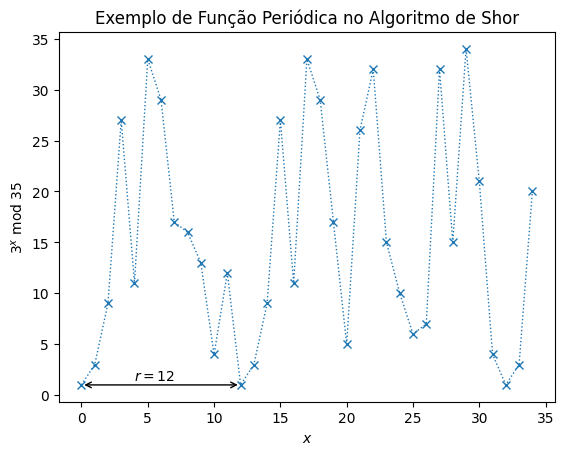

In [2]:
N = 35
a = 3
# Calcular os dados para o gráfico
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Usar matplotlib para apresentar de forma clara
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Exemplo de Função Periódica no Algoritmo de Shor")
try: # Desenhar r no gráfico
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Não foi possível encontrar o período, verifique se a < N e se não têm fatores comuns.')


## 2. A solução

A solução de Shor foi usar a [estimativa de fase quântica](./quantum-phase-estimation.html) no operador unitário:

$$ U|y\rangle \equiv |ay \bmod N \rangle $$

Para ver como isto é útil, vamos calcular como será um estado próprio de U. Se começarmos no estado $|1\rangle$, podemos ver que cada aplicação sucessiva de U multiplicará o estado do nosso registo por $a \pmod N$ e, após $r$ aplicações, chegaremos novamente ao estado $|1\rangle$. Por exemplo, com $a = 3$ e $N = 35$:

$$\begin{aligned}
U|1\rangle &= |3\rangle & \\
U^2|1\rangle &= |9\rangle \\
U^3|1\rangle &= |27\rangle \\\
& \vdots \\\
U^{(r-1)}|1\rangle &= |12\rangle \\\
U^r|1\rangle &= |1\rangle 
\end{aligned}$$

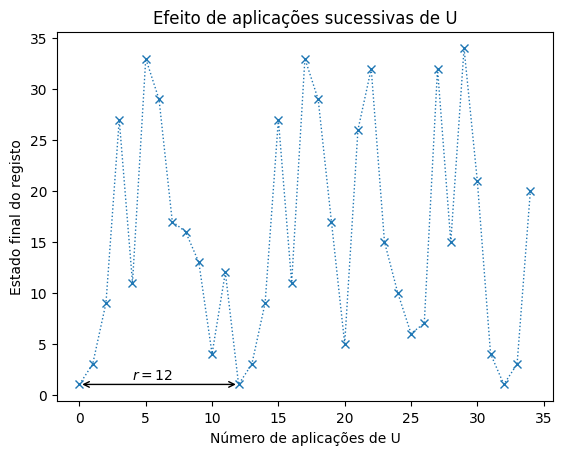

In [3]:
ax.set(xlabel='Número de aplicações de U',
       ylabel='Estado final do registo',
       title='Efeito de aplicações sucessivas de U')
fig


Então, uma superposição dos estados neste ciclo ($|u_0\rangle$) seria um autovetor de $U$:

$$|u_0\rangle = \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{|a^k \bmod N\rangle} $$


Este autovetor tem um autovalor de 1, o que não é muito interessante. Um autovetor mais interessante poderia ser um em que a fase fosse diferente para cada um destes estados da base computacional. Especificamente, vejamos o caso em que a fase do estado $k^\text{th}$ é proporcional a $k$:

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{r}}|u_1\rangle 
\end{aligned}
$$

Este é um autovalor particularmente interessante, pois contém $r$. De facto, $r$ deve ser incluído para garantir que as diferenças de fase entre os $r$ estados da base computacional sejam iguais. Este não é o único autovetor com este comportamento; para generalizar ainda mais, podemos multiplicar um número inteiro, $s$, a esta diferença de fase, o que será refletido no nosso autovalor:

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i s k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{r}}|u_s\rangle 
\end{aligned}
$$

Agora temos um autovetor único para cada valor inteiro de $s$, onde $0 \leq s \leq r-1.$ Muito convenientemente, se somarmos todos estes autovetores, as diferentes fases cancelam todos os estados da base computacional, exceto $|1\rangle$:

$$ \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} |u_s\rangle = |1\rangle$$

Como o estado da base computacional $|1\rangle$ é uma superposição destes autovetores, significa que, se realizarmos a QPE sobre $U$ utilizando o estado $|1\rangle$, mediremos uma fase:

$$\phi = \frac{s}{r}$$

Onde $s$ é um inteiro aleatório entre $0$ e $r-1$. Finalmente, utilizamos o algoritmo de [frações contínuas](https://en.wikipedia.org/wiki/Continued_fraction) sobre $\phi$ para encontrar $r$. O diagrama do circuito é o seguinte (note que este diagrama utiliza a convenção de ordenação de qubits do Qiskit):

<img src="images/shor_circuit_1.svg">

De seguida, demonstraremos o algoritmo de Shor utilizando os simuladores do Qiskit.


## 3. Implementação do Qiskit

Neste exemplo vamos resolver o problema de encontrar o período para $a=7$ e $N=15$. Fornecemos os circuitos para $U$ onde:

$$U|y\rangle = |ay\bmod 15\rangle $$

Para criar $U^x$, vamos simplesmente repetir o circuito $x$ vezes.


In [4]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

Vamos usar 8 qubits de contagem.

In [5]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

Também importamos o circuito para a QFT (pode ler mais sobre a QFT no capítulo [transformada quântica de Fourier](./quantum-fourier-transform.html#generalqft)):


In [6]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

Com estes blocos, podemos construir facilmente o circuito para o algoritmo de Shor:


In [7]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

Medições usando simulador

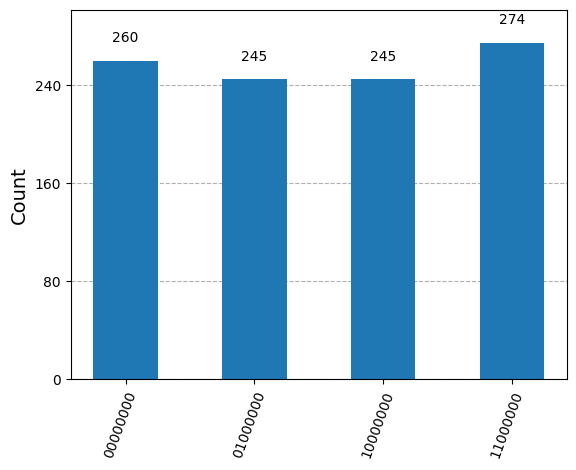

In [8]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

Como temos 8 qubits, estes resultados correspondem a fases medidas de:

In [9]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  10000000(bin) = 128(dec)  128/256 = 0.50
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  00000000(bin) =   0(dec)    0/256 = 0.00


Podemos agora utilizar o algoritmo das fracções contínuas para tentar encontrar $s$ e $r$. Python tem essa funcionalidade embutida: Podemos usar o módulo `fractions` para transformar um float num objeto `Fraction`, por exemplo:

Como isso dá frações que retornam o resultado exatamente, isso pode dar resultados esquisitos, usamos então o método `.limit_denominator()` para obter a fração que mais se assemelha ao nosso float, com denominador abaixo de um certo valor:

In [10]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

A ordem (r) tem de ser menor que N, por isso vamos definir o denominador máximo como `15`:

In [11]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.50      1/2            2
2   0.25      1/4            4
3   0.00      0/1            1


Podemos ver que dois dos valores próprios medidos deram o resultado correto: $r=4$, e podemos ver que o algoritmo de Shor tem uma hipótese de falhar.

Estes maus resultados devem-se ao facto de $s = 0$, ou porque $s$ e $r$ não são coprimos e, em vez de $r$, é-nos dado um fator de $r$. A solução mais fácil para isto é simplesmente repetir a experiência até obtermos um resultado satisfatório para $r$.

Mediçoes em HW real - fins experimentais

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

TOKEN = '24529c0b1504e588ec45d6f64994f362be5ff6559dca2b4c974466d6a18243431d8c02a49553ab0da5efbea6ba1473e0ed797715a98a09dd449f51a45c090456'
service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)


In [13]:

real_backend = service.least_busy(operational=True, simulator=False)
sampler = Sampler(real_backend)
print(real_backend)


<IBMBackend('ibm_kyiv')>


In [14]:
# Transpilar o circuito para o hardware real
t_qc = transpile(qc, real_backend)

# Executar o circuito no hardware real
shor_job = sampler.run([t_qc], shots=2048)


In [15]:
shor_job.job_id()

'cy76428rta1g00878xc0'

In [16]:
job = service.job(shor_job.job_id())
job_result = job.result()[0]

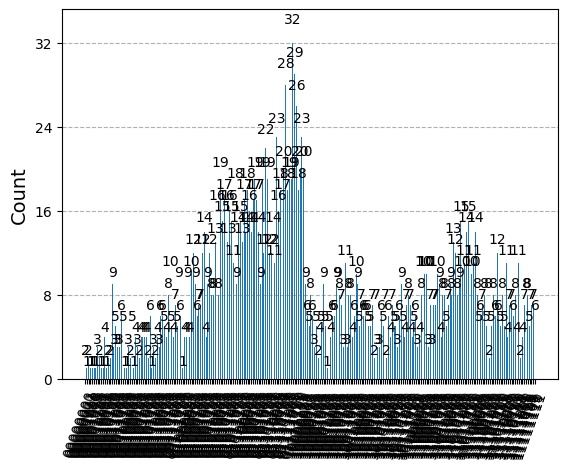

In [45]:
from collections import Counter

# Obter todas as contagens
counts = Counter(job_result.data.c.get_bitstrings())

# Filtrar apenas bitstrings com contagens superiores a 10
filtered_counts = {bitstring: count for bitstring, count in counts.items() if count <25}

# Verificar se há bitstrings a serem plotados
plot_histogram(counts)


In [44]:
rows, measured_phases = [], []
for output in filtered_counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

              Register Output           Phase
0    01010010(bin) =  82(dec)   82/256 = 0.32
1    00111010(bin) =  58(dec)   58/256 = 0.23
2    10011000(bin) = 152(dec)  152/256 = 0.59
3    01110100(bin) = 116(dec)  116/256 = 0.45
4    01101011(bin) = 107(dec)  107/256 = 0.42
..                        ...             ...
241  00100001(bin) =  33(dec)   33/256 = 0.13
242  00111100(bin) =  60(dec)   60/256 = 0.23
243  00001010(bin) =  10(dec)   10/256 = 0.04
244  00001101(bin) =  13(dec)   13/256 = 0.05
245  10001100(bin) = 140(dec)  140/256 = 0.55

[246 rows x 2 columns]


In [47]:
rows = []
# Iterar sobre as fases medidas
for phase in measured_phases:
    # Converter a fase em uma fração aproximada
    frac = Fraction(phase).limit_denominator(15)
    r = frac.denominator  # Obter o denominador como a guess para r

    # Verificar se r é um período válido
    is_valid = pow(a, r, N) == 1

    # Adicionar os resultados à tabela
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", r, "Sim" if is_valid else "Não"])

# Criar o DataFrame
headers = ["Phase", "Fraction", "Guess for r", "Is Valid"]
df = pd.DataFrame(rows, columns=headers)

# Contar o número de guesses válidas e inválidas
valid_count = df["Is Valid"].value_counts().get("Sim", 0)
invalid_count = df["Is Valid"].value_counts().get("Não", 0)
total_count = len(df)

# Calcular a taxa de erro
error_rate = (invalid_count / total_count) * 100 if total_count > 0 else 0

# Exibir a tabela, número de guesses válidas e taxa de erro
print(df)
print(f"Número de guesses válidas: {valid_count}")
print(f"Número de guesses inválidas: {invalid_count}")
print(f"Taxa de erro: {error_rate:.2f}%")

        Phase Fraction  Guess for r Is Valid
0    0.320312     4/13           13      Não
1    0.226562     3/13           13      Não
2    0.593750      3/5            5      Não
3    0.453125     5/11           11      Não
4    0.417969     5/12           12      Sim
..        ...      ...          ...      ...
241  0.128906      1/8            8      Sim
242  0.234375     3/13           13      Não
243  0.039062     1/15           15      Não
244  0.050781     1/15           15      Não
245  0.546875     6/11           11      Não

[246 rows x 4 columns]
Número de guesses válidas: 34
Número de guesses inválidas: 212
Taxa de erro: 86.18%


## Análise dos Resultados Obtidos

Após a execução do algoritmo de Shor em hardware quântico, obtivemos os resultados no histograma da Figura. Cada valor medido no histograma corresponde a uma sequência de bits que representa a saída do registo quântico. Para interpretar os resultados, convertêmo-los em fases medidas através da relação:

\[
\text{fase} = \frac{\text{valor decimal}}{2^{N_{\text{COUNT}}}},
\]

onde \( N_{\text{COUNT}} = 8 \), correspondente ao número de qubits utilizados para o registo de controlo. A tabela abaixo apresenta alguns exemplos dos valores medidos, convertidos em fase:

| Register Output | Decimal (dec) | Phase (fase) |
|-----------------|---------------|--------------|
| 01010010 (bin)  | 82            | 0.32         |
| 00111010 (bin)  | 58            | 0.23         |
| 10011000 (bin)  | 152           | 0.59         |
| 01110100 (bin)  | 116           | 0.45         |

Utilizando as fases obtidas, aplicámos o algoritmo de frações contínuas para aproximá-las em frações com denominadores limitados a \( N = 15 \), de forma a determinar valores candidatos para o período \( r \). A função Python `Fraction.limit_denominator()` foi utilizada para este propósito, e os resultados estão sumarizados na tabela abaixo:

| Phase (fase) | Fraction (fração) | Guess for r (estimativa para \( r \)) |
|--------------|-------------------|--------------------------------------|
| 0.320312     | 4/13             | 13                                   |
| 0.226562     | 3/13             | 13                                   |
| 0.593750     | 3/5              | 5                                    |
| 0.453125     | 5/11             | 11                                   |

### Discussão dos Resultados

Os resultados mostram várias estimativas para o período \( r \). No entanto, como esperado para o caso \( N = 15 \) e \( a = 7 \), os valores de \( r \) que aparecem com maior frequência e consistência no histograma são múltiplos de 15. Estes resultados refletem a periodicidade subjacente à exponenciação modular e a precisão do algoritmo de Shor em identificar o período correto.

Adicionalmente, os valores \( r \) que não correspondem diretamente ao período esperado podem ser atribuídos a efeitos de ruído e imperfeições no hardware quântico real, algo que é comum em simulações práticas. Apesar disso, a alta frequência de medições corretas demonstra a robustez do algoritmo.



## 4.Factorização a partir da Determinação do Período

Nem todos os problemas de factorização são difíceis; podemos identificar instantaneamente um número par e saber que um dos seus factores é 2. De facto, existem [critérios específicos](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.186-4.pdf#%5B%7B%22num%22%3A127%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C70%2C223%2C0%5D) para escolher números difíceis de fatorizar, mas a ideia básica é escolher o produto de dois números primos grandes.
Um algoritmo geral de factorização começará por verificar se existe um atalho para fatorizar o número inteiro (o número é par? O número é da forma $N = a^b$?), antes de utilizar o cálculo do período de Shor para o pior cenário. Como o nosso objetivo é focarmo-nos na parte quântica do algoritmo, vamos saltar diretamente para o caso em que N é o produto de dois primos.

### Exemplo: Factorização de 15

Para ver um exemplo de factorização num pequeno número de qubits, vamos faturar 15, que todos sabemos ser o produto dos números primos não tão grandes 3 e 5.


In [18]:
N = 15

O primeiro passo é escolher um número aleatório, $a$, entre $1$ e $N-1$:


In [19]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

7


Em seguida, verificamos rapidamente que não é já um fator não trivial de $N$:

In [20]:
from math import gcd # greatest common divisor
gcd(a, N)

1

Ótimo. A seguir, fazemos o algoritmo de Shor para encontrar a ordem para `a = 7` e `N = 15`. Lembre-se que a fase que medimos será $s/r$ onde:

$$ a^r \bmod N = 1 $$

e $s$ é um número inteiro aleatório entre 0 e $r-1$.


In [21]:
def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

A partir desta fase, podemos facilmente encontrar uma estimativa para $r$:


In [22]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15)

Register Reading: 01000000
Corresponding Phase: 0.25


Fraction(1, 4)

In [23]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

4


Agora que temos $r$, talvez possamos usá-lo para encontrar um fator de $N$. Uma vez que:

$$a^r \bmod N = 1 $$

então:

$$(a^r - 1) \bmod N = 0 $$

o que significa que $N$ tem de dividir $a^r-1$. E se $r$ também for par, então podemos escrever:

$$a^r -1 = (a^{r/2}-1)(a^{r/2}+1)$$

(se $r$ não for par, não podemos ir mais longe e temos de tentar novamente com um valor diferente para $a$). Existe então uma grande probabilidade de que o maior divisor comum de $N$ e de $a^{r/2}-1$, ou de $a^{r/2}+1$ seja um fator próprio de $N$:


In [24]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 5]


A célula abaixo repete o algoritmo até que pelo menos um fator de 15 seja encontrado.
Deve tentar executar novamente a célula algumas vezes para ver como se comporta.


In [25]:
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 2:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 3:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 4:
Register Reading: 11000000
Corresponding Phase: 0.75
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


In [26]:
# A célula abaixo repete o algoritmo até que pelo menos um fator de 15
# seja encontrado

assert (3 in guesses) or (5 in guesses)

## 6. References

1. Stephane Beauregard, _Circuit for Shor's algorithm using 2n+3 qubits,_ [arXiv:quant-ph/0205095](https://arxiv.org/abs/quant-ph/0205095)

2. M. Nielsen and I. Chuang, _Quantum Computation and Quantum Information,_ Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000). (Page 633)